In [ ]:
!pip install tensorflow==2.16.1

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = '/content/drive/MyDrive/masked_dataset'
categories = ['Benign', 'Early', 'Pre', 'Pro']

In [ ]:
data = []
for category in categories:
    category_dir = os.path.join(base_dir, category)
    for filename in os.listdir(category_dir):
        data.append((os.path.join(category_dir, filename), category))

df = pd.DataFrame(data, columns=['filename', 'category'])

df['label'] = df['category'].astype('category').cat.codes

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="category",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode= 'rgb',
    shuffle= True,
    seed=42
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col="filename",
    y_col="category",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode= 'rgb',
    shuffle=False
)

test_generator = validation_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="category",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode= 'rgb',
    shuffle=False
)

Found 2083 validated image filenames belonging to 4 classes.
Found 521 validated image filenames belonging to 4 classes.
Found 652 validated image filenames belonging to 4 classes.


# DenseNet201


In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:300]:
    layer.trainable = False
for layer in base_model.layers[300:]:
    layer.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ ?                           │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 14,028,480 (53.51 MB)

 Non-trainable params: 4,293,504 (16.38 MB)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    verbose=1,
    batch_size=16,
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)

Epoch 1/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.2825 - loss: 2.7941 - val_accuracy: 0.3359 - val_loss: 1.9388 - learning_rate: 1.0000e-05
Epoch 2/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 107s 353ms/step - accuracy: 0.4245 - loss: 2.3228 - val_accuracy: 0.7428 - val_loss: 1.4037 - learning_rate: 1.0000e-05
Epoch 3/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 410ms/step - accuracy: 0.4996 - loss: 2.0767 - val_accuracy: 0.7716 - val_loss: 1.2531 - learning_rate: 1.0000e-05
Epoch 4/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 75s 354ms/step - accuracy: 0.5652 - loss: 1.8986 - val_accuracy: 0.7985 - val_loss: 1.1537 - learning_rate: 1.0000e-05
Epoch 5/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 358ms/step - accuracy: 0.5874 - loss: 1.7704 - val_accuracy: 0.8157 - val_loss: 1.0778 - learning_rate: 1.0000e-05
Epoch 6/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 423ms/step - accuracy: 0.6247 - loss: 1.6412 - val_accuracy: 0.8234 - val_loss: 1.0404 - learning_rate: 1.0000e-05
Epoch 7/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 419

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 380ms/step - accuracy: 0.9315 - loss: 0.6917
Test Loss: 0.6941527128219604
Test Accuracy: 0.9263803958892822


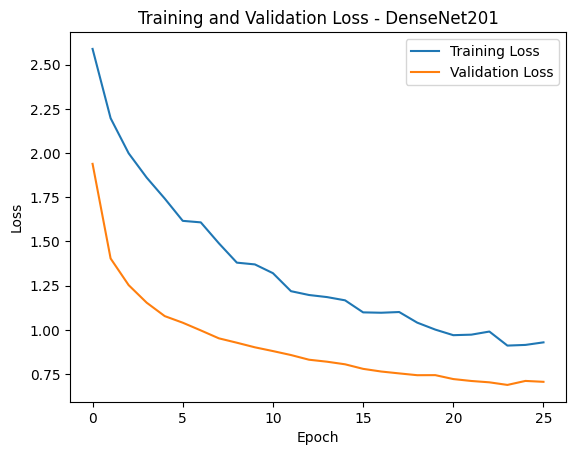

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - DenseNet201')
plt.legend()
plt.show()

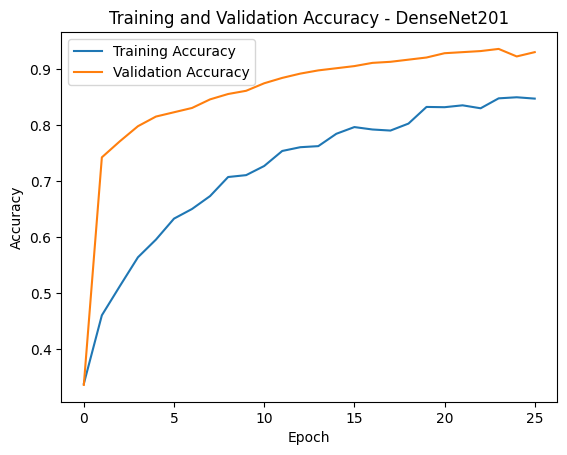

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - DenseNet201')
plt.legend()
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 520ms/step


<Figure size 1000x600 with 0 Axes>

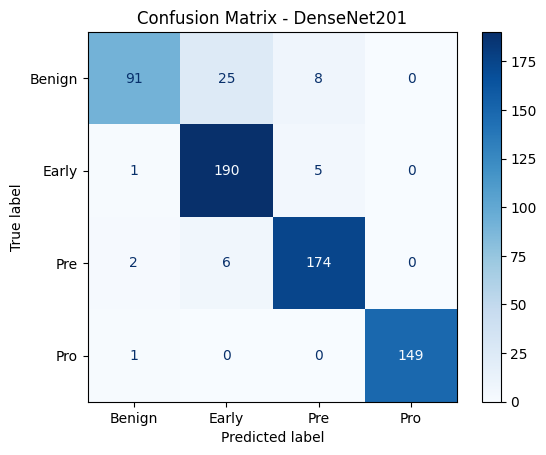

In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - DenseNet201')
plt.show()

In [ ]:
report = classification_report(y_true, y_pred_classes, target_names=categories)
accuracy = accuracy_score(y_true, y_pred_classes)

print("DenseNet201 Classification Report:")
print(report)
print("DenseNet201 Accuracy:", accuracy)

DenseNet201 Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.73      0.83       124
       Early       0.86      0.97      0.91       196
         Pre       0.93      0.96      0.94       182
         Pro       1.00      0.99      1.00       150

    accuracy                           0.93       652
   macro avg       0.94      0.91      0.92       652
weighted avg       0.93      0.93      0.92       652

DenseNet201 Accuracy: 0.9263803680981595


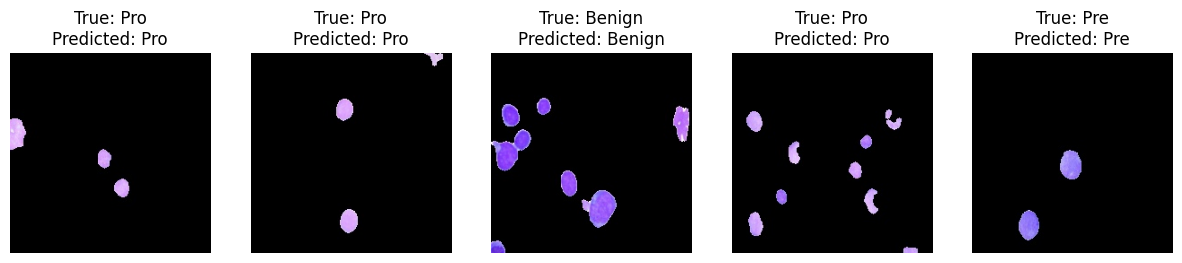

In [ ]:
sample_size = 5
random_indices = random.sample(range(len(test_df)), sample_size)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    filename = test_df.iloc[idx]['filename']
    true_label = test_df.iloc[idx]['category']
    img = plt.imread(filename)
    plt.subplot(1, sample_size, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'True: {true_label}\nPredicted: {categories[y_pred_classes[idx]]}')

plt.show()

In [ ]:
model.save('/content/drive/My Drive/densenet201.h5')